In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils

%matplotlib inline

In [4]:
%cd pygranso

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/PyGRANSO


In [5]:
# first party
# Import pygranso functionality
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [6]:
def structural_optimization_function(model, ke, args, designs, debug=False):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = cnn_model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )

    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)
    
    # Run this problem with no inequality constraints
    ci = None
    
    # Run this problem with no equality constraints
    ce = None
    
    designs.append(topo_physics.physical_density(logits, args, volume_constraint=True))
    
    return f, ci, ce

## PyGranso Initializations

This is where we will set up the problem and also the options to run pygranso

In [10]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 5e-6
opts.linesearch_maxit = 50

In [11]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_48074/1907579639.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_48074/1907579639.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

  54 ║  - │   -   ║  204.811678570 ║   -  │   -  ║ QN │    18 │ 0.655360 ║     1 │ 0.054873   ║ 
  55 ║  - │   -   ║  204.605606480 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.049660   ║ 
  56 ║  - │   -   ║  204.476099113 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.120003   ║ 
  57 ║  - │   -   ║  204.433865500 ║   -  │   -  ║ QN │    18 │ 0.655360 ║     1 │ 0.023238   ║ 
  58 ║  - │   -   ║  204.388634505 ║   -  │   -  ║ QN │    18 │ 0.655360 ║     1 │ 0.038491   ║ 
  59 ║  - │   -   ║  204.297405356 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.041508   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
     ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
  60 ║  - │   -   ║  204.0852270

 123 ║  - │   -   ║  200.222720580 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.003162   ║ 
 124 ║  - │   -   ║  200.209291242 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.014992   ║ 
 125 ║  - │   -   ║  200.198029316 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.003984   ║ 
 126 ║  - │   -   ║  200.186342753 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.002758   ║ 
 127 ║  - │   -   ║  200.179455302 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.008315   ║ 
 128 ║  - │   -   ║  200.170552498 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.012561   ║ 
 129 ║  - │   -   ║  200.163906203 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.004093   ║ 
 130 ║  - │   -   ║  200.160037120 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.002886   ║ 
 131 ║  - │   -   ║  200.155577046 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.001836   ║ 
 132 ║  - │   -   ║  200.148410600 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.002438   ║ 
 133 ║  - │   -   ║  200.13898

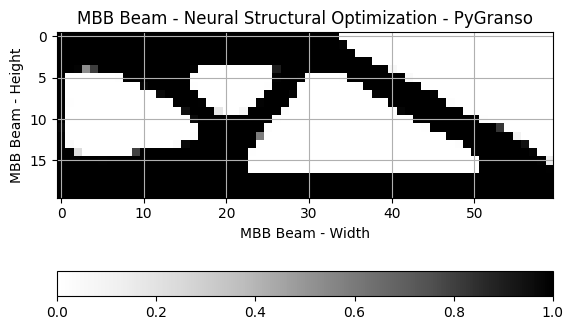

In [18]:
# Get the final frame
final_frame = designs[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - PyGranso')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
ax.grid()
fig.colorbar(im, orientation="horizontal", pad=0.2)